# Implementation of face recognition using neural net 

In [89]:
%matplotlib inline

In [90]:
import cv2
import numpy as np
import os
from skimage import io
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,accuracy_score
from sklearn.neural_network import MLPClassifier


In [91]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import metrics

#### Listing the path of all the images

In [92]:
DatasetPath = []
for i in os.listdir("yalefaces"):
    DatasetPath.append(os.path.join("yalefaces", i))

#### Reading each image and assigning respective labels

In [93]:
imageData = []
imageLabels = []

In [94]:
for i in DatasetPath:
    imgRead = io.imread(i,as_grey=True)
    imageData.append(imgRead)
    
    labelRead = int(os.path.split(i)[1].split(".")[0].replace("subject", "")) - 1
    imageLabels.append(labelRead)

#### Preprocessing: Face Detection using OpenCV and cropping the image to a size of 150 * 150

In [95]:
faceDetectClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
imageDataFin = []
for i in imageData:
    facePoints = faceDetectClassifier.detectMultiScale(i)
    x,y = facePoints[0][:2]
    cropped = i[y: y + 150, x: x + 150]
    imageDataFin.append(cropped)

In [96]:
c = np.array(imageDataFin)

In [97]:
c.shape

(165, 150, 150)

#### Splitting Dataset into train and test

In [98]:
X_train, X_test, y_train, y_test = train_test_split(np.array(imageDataFin),np.array(imageLabels), train_size=0.5, random_state = 20)

In [99]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [100]:
X_train.shape

(82, 150, 150)

In [101]:
X_test.shape

(83, 150, 150)

In [102]:
nb_classes = 15
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [103]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#### Converting each 2d image into 1D vector

In [104]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255

#### Preprocessing -PCA

Plot of amount of variance explained vs pcs


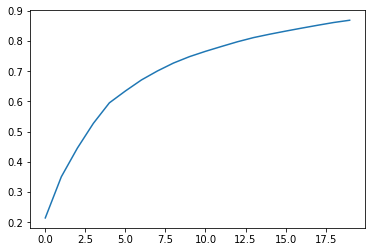

('Training PCA shape', (82, 20))
('Test PCA shape', (83, 20))
Eigen Faces


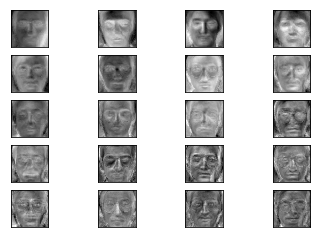

In [105]:
computed_pca = PCA(n_components = 20,whiten=True).fit(X_train)
XTr_pca = computed_pca.transform(X_train)

print("Plot of amount of variance explained vs pcs")
plt.plot(range(len(computed_pca.explained_variance_)),np.cumsum(computed_pca.explained_variance_ratio_))
plt.show()

XTs_pca = computed_pca.transform(X_test)
print("Training PCA shape",XTr_pca.shape)
print("Test PCA shape",XTs_pca.shape)


def plot_eigenfaces(images, h, w, rows=5, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
plot_eigenfaces(computed_pca.components_,150,150)
print("Eigen Faces")

In [106]:
print("Original Training matrix shape", X_train.shape)
print("Original Testing matrix shape", X_test.shape)

('Original Training matrix shape', (82, 22500))
('Original Testing matrix shape', (83, 22500))


#### Defining the model

In [107]:
model = Sequential()
model.add(Dense(512,input_shape=(XTr_pca.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               10752     
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 15)                7695      
__________

In [109]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.mae,metrics.categorical_accuracy])

#### Training

In [110]:
model.fit(XTr_pca, Y_train, batch_size=64, epochs=50, verbose=1, validation_data=(XTs_pca, Y_test))

Train on 82 samples, validate on 83 samples
Epoch 1/50
82/82 [==============================] - 1s 8ms/step - loss: 2.7087 - mean_absolute_error: 0.1242 - categorical_accuracy: 0.0854 - val_loss: 2.4871 - val_mean_absolute_error: 0.1220 - val_categorical_accuracy: 0.4337
Epoch 2/50
82/82 [==============================] - 0s 303us/step - loss: 2.2800 - mean_absolute_error: 0.1191 - categorical_accuracy: 0.6098 - val_loss: 2.2995 - val_mean_absolute_error: 0.1191 - val_categorical_accuracy: 0.6024
Epoch 3/50
82/82 [==============================] - 0s 280us/step - loss: 1.9458 - mean_absolute_error: 0.1130 - categorical_accuracy: 0.7805 - val_loss: 2.1263 - val_mean_absolute_error: 0.1155 - val_categorical_accuracy: 0.6024
Epoch 4/50
82/82 [==============================] - 0s 295us/step - loss: 1.6055 - mean_absolute_error: 0.1046 - categorical_accuracy: 0.9268 - val_loss: 1.9518 - val_mean_absolute_error: 0.1107 - val_categorical_accuracy: 0.6145
Epoch 5/50
82/82 [====================

82/82 [==============================] - 0s 315us/step - loss: 0.0062 - mean_absolute_error: 8.1724e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5491 - val_mean_absolute_error: 0.0318 - val_categorical_accuracy: 0.8072
Epoch 37/50
82/82 [==============================] - 0s 280us/step - loss: 0.0070 - mean_absolute_error: 9.1561e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5468 - val_mean_absolute_error: 0.0316 - val_categorical_accuracy: 0.8072
Epoch 38/50
82/82 [==============================] - 0s 262us/step - loss: 0.0063 - mean_absolute_error: 8.3348e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5441 - val_mean_absolute_error: 0.0314 - val_categorical_accuracy: 0.8072
Epoch 39/50
82/82 [==============================] - 0s 293us/step - loss: 0.0063 - mean_absolute_error: 8.2202e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5415 - val_mean_absolute_error: 0.0312 - val_categorical_accuracy: 0.8072
Epoch 40/50
82/82 [==============================] - 0s 282us/step - los

#### Evaluating the performance

In [111]:
loss,mean_absolute_error,accuracy = model.evaluate(XTs_pca,Y_test, verbose=0)

In [112]:
print("Loss:", loss)
print("Categorical Accuracy: ", accuracy)
print("Mean absolute error: ", mean_absolute_error)

('Loss:', 0.54880275999207095)
('Categorical Accuracy: ', 0.79518072073718149)
('Mean absolute error: ', 0.030896608414779227)


In [113]:
predicted_classes = model.predict_classes(XTs_pca)

In [114]:
correct_classified_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_classified_indices = np.nonzero(predicted_classes != y_test)[0]

In [115]:
print("Correctly Classified: ", len(correct_classified_indices))
print("Incorrectly Classified: ", len(incorrect_classified_indices))



('Correctly Classified: ', 66)
('Incorrectly Classified: ', 17)


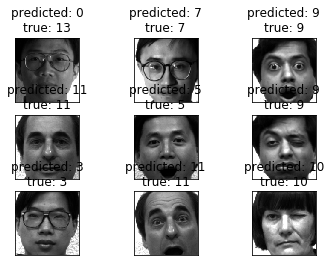

In [116]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=3):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
def titles(y_pred, y_test):
    for i in range(y_pred.shape[0]):
        pred_name = y_pred[i]
        true_name = y_test[i]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
        
prediction_titles = list(titles(predicted_classes, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)

